# <font color=#b59700><center>Dealing with missing values - NaN</center></font>

### <font color=#b59700>About this notebook</font>

In this notebook I will first theoretically cover the basic ways of dealing with missing values, then we will load some clean dataset, create a function that will corrupt the dataset by specific % and finally we will test how the way we deal with the missing values will turn out against the original dataset


### <font color=#b59700>Introduction</font>


Dealing with missing values is one the most important parts in the whole process, be it preparing presentation, cleaning the data for learning a model or just making sense of dataset in general. I feel like I'm saying that some part is one of the most important one almost in every list, but it's especially true here. If you have clean data to start with, you have saved a lot of time and hard decision making. __Because the way you decide to clean / fill your missing data can have critical impact on the data representation or learning a model.__
* delete all missing values can shrink your dataset in an unusable state
* filling all data with average value can greatly distort the shape of distribution curve
* creating too complex function to fill the missing values can have unexpected and hard to identify impact on your dataset
* ignoring data with missing values can lead into overlooking some important insight
* etc

__Thus the decision on how to deal with the missing values might be unexpectedly hard and can steer the way all your further work will develop__



NaN is short for Not A Number, which can be a little missleading, but it acts the same way as NA (Not Available) and these terms can be used interchangeably, it is so mainly for performance reason. Even tho there are some differences - I would suggest you read the pandas documentation for it, named Working with missing data. There you will find few things, like comparison differences for nan's (not equal) and Pythons native None (equal) and likewise. But for our actual purposes we wont be diving into those details. For brief introduction a few important things:

* these types refer to missing values - for example reading csv: 10,0,,5 - this input would be loaded as Series/DF with third value marked as NaN, 0 is a valid value. This seems logical, but just pointing it out here
* NaN values acts as 0 in Sum, trying to Sum Series full of NaNs would end up being 0
* Groupby function automatically exluced the NaN values, so they wont be in your groupby object
* NaN by default is a float - thus a column with at least 1 NaN value will be casted into float
* Pandas provide NaN for numeric values and NaT (Not a Datetime) for dates. Those two types are compatible

This would be just a fast summary from the docs. Now that we know what we are working with, lets see what functions we can use to deal with our missing or corrupted data.

##### <font color=#b59700>locating the missing data</font>
* __isnull()__ - marks the NaN values as True, rest as False
* __notnull()__ - marks the values that are not NaN as True, and missing values as false

These 2 functions are our main method of locating the missing values. The power in the binary True/False mask is the fact, that logical True is 1 and logical False is 0, thus we can do math operations on them, allowing us to easly and instantly summarize the range of the missing values even on a huge datasets. Plus there are some other functions like pd.info() that will tell you the number of missing values.

##### <font color=#b59700>working with the missing data</font>
* __dropna()__ 
    * drops rows or colums - axis=0 (rows), axis=1 (columns)
    * delete based on number of missing values - how="any" (deletes all if at least 1 occurence of NaN, default), how="all" (only if all values are NaN)
* __fillna()__
    * fills NaN with a specific value, like integer, string etc
    * param method can be used to specify how to fill vlaues
        * pad / ffill - fill values forward
        * bfill / backfill - fill values backward
    * parm limit can limit the number of NaN values to be filled
* __replace()__
    * the basic replacement goes like this: series.replace(index, value)
    * you can replace specific values with dict, like this: dataframe.replace({"col1" : 0, "col5" : 5}, 100) replaces specific values with 100 
* __interpolate()__
    * interpolation has many methods to fill the missing values like linear - treat the values as equally spaced. Many interpolation methods use SciPy interpolations, like zero, quadratic, cubic, spline etc 


##### <font color=#b59700>Lets start with some code</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.figsize":(16,8)})

I have one database that could serve us well here, it is a animal shelter database, lets load it and then create a function that will pollute our data and start testing some filling functions

In [2]:
path = ".jupyter\\datasets\\cleaned\\"
df = pd.read_csv(path + "shelter_outcomes.csv", index_col=0) 
# index_col=0 uses first row as index, by default read_csv creates new index column, so we would have duplicate

df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,out_age_in_weeks,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07 00:00:00,2014-07-22 16:04:00,2,not filled,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06 00:00:00,2013-11-07 11:47:00,52,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31 00:00:00,2014-06-03 14:20:00,52,*Johnny,none,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02 00:00:00,2014-06-15 15:50:00,469,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07 00:00:00,2014-07-07 14:04:00,21,not filled,Rabies Risk,Euthanasia,Unknown


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78256 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  78256 non-null  object
 1   animal_id         78256 non-null  object
 2   animal_type       78256 non-null  object
 3   breed             78256 non-null  object
 4   color             78256 non-null  object
 5   date_of_birth     78256 non-null  object
 6   datetime          78256 non-null  object
 7   out_age_in_weeks  78256 non-null  int64 
 8   name              78256 non-null  object
 9   outcome_subtype   78256 non-null  object
 10  outcome_type      78256 non-null  object
 11  sex_upon_outcome  78256 non-null  object
dtypes: int64(1), object(11)
memory usage: 7.8+ MB


In [4]:
# change the data type for dates
df[["date_of_birth", "datetime"]] = df[["date_of_birth", "datetime"]].apply(pd.to_datetime)

Now lets write function that will corrupt our dataset to the required degree

In [5]:
import random

def corrupt_df(df, column_indexes, percent_corrupt):
    new_df = df.copy()
    corrupt_count = int((len(df)/100)*percent_corrupt)
    indexes_to_corrupt = random.sample(range(0, len(df)), corrupt_count)
    for row_index in indexes_to_corrupt:
        for col_index in column_indexes:
            new_df.iloc[row_index, col_index]=np.NaN
    return new_df

with function done, lets create some dummy datasets so we can start working on them, I will name them as test_ + the percent of the corruption of the selected columns

In [6]:
test_5 = corrupt_df(df, [2, 5, 6, 7, 10], 5)
test_10 = corrupt_df(df, [2, 5, 6, 7, 10], 10)
test_20 = corrupt_df(df, [2, 5, 6, 7, 10], 20)
test_40 = corrupt_df(df, [2, 5, 6, 7, 10], 40)
test_60 = corrupt_df(df, [2, 5, 6, 7, 10], 60)

In [7]:
test_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78256 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   age_upon_outcome  78256 non-null  object        
 1   animal_id         78256 non-null  object        
 2   animal_type       70431 non-null  object        
 3   breed             78256 non-null  object        
 4   color             78256 non-null  object        
 5   date_of_birth     70431 non-null  datetime64[ns]
 6   datetime          70431 non-null  datetime64[ns]
 7   out_age_in_weeks  70431 non-null  float64       
 8   name              78256 non-null  object        
 9   outcome_subtype   78256 non-null  object        
 10  outcome_type      70431 non-null  object        
 11  sex_upon_outcome  78256 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(9)
memory usage: 7.8+ MB


In [8]:
test_40.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78256 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   age_upon_outcome  78256 non-null  object        
 1   animal_id         78256 non-null  object        
 2   animal_type       46954 non-null  object        
 3   breed             78256 non-null  object        
 4   color             78256 non-null  object        
 5   date_of_birth     46954 non-null  datetime64[ns]
 6   datetime          46954 non-null  datetime64[ns]
 7   out_age_in_weeks  46954 non-null  float64       
 8   name              78256 non-null  object        
 9   outcome_subtype   78256 non-null  object        
 10  outcome_type      46954 non-null  object        
 11  sex_upon_outcome  78256 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(9)
memory usage: 7.8+ MB


With code above we confirmed that the function worked as it should (hopefully ...). The last step before we really start is to visualize and summarize the datasets as they are now, to see the impact of our further work. I will sort the datasets for specific tasks so the differences will be more clear

In [9]:
# overall this function is a really bad practice as there are some hardcoded names from this specific dataset !!!
# we will use "animal_id" as a counter for aggregate function as hardcoded part
# column_name param will choose which column we want to do aggregation on 
# I am creating this function bcs we will do agg and sort functions on more columns

def sort_by_column(df, column_name):
    grouped = df.groupby(column_name, as_index=False)["animal_id"].count()
    grouped.sort_values(by="animal_id", ascending=False, inplace=True) # sorting the groupby object
    grouped.rename(columns = {"animal_id":"count"}, inplace=True) # renaming column to show it represents count
    return grouped

Text(0.5, 1.0, '60% corruption')

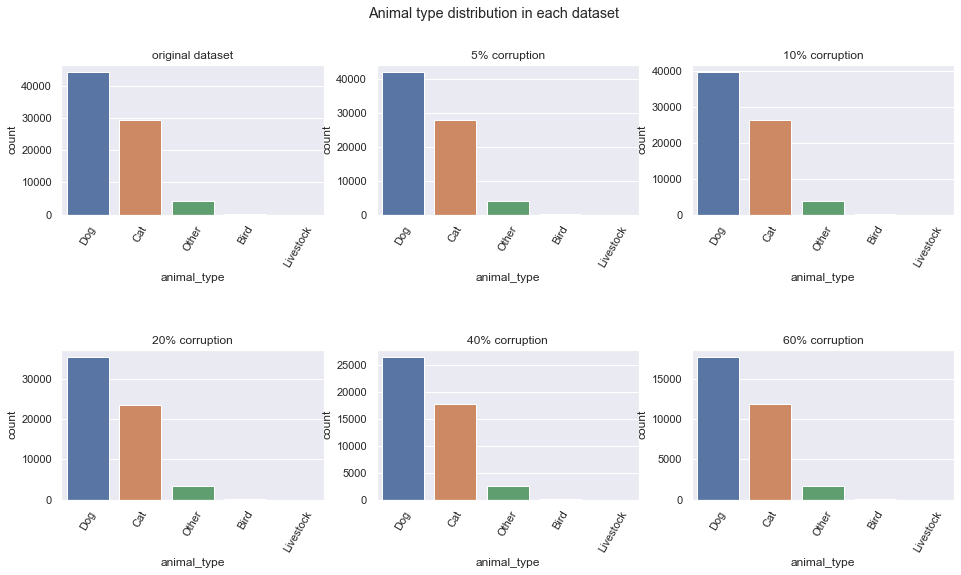

In [10]:
fig, ax = plt.subplots(2,3)
fig.subplots_adjust(hspace=0.9)
fig.suptitle("Animal type distribution in each dataset")

col = "animal_type"
y_axis = "count"

g = sns.barplot(data=sort_by_column(df,col), x=col, y=y_axis, ax=ax[0,0])
g.set_xticklabels(g.get_xticklabels(), rotation=60)
ax[0,0].set_title("original dataset")

g = sns.barplot(data=sort_by_column(test_5,col), x=col, y=y_axis, ax=ax[0,1])
g.set_xticklabels(g.get_xticklabels(), rotation=60)
ax[0,1].set_title("5% corruption")

g = sns.barplot(data=sort_by_column(test_10,col), x=col, y=y_axis, ax=ax[0,2])
g.set_xticklabels(g.get_xticklabels(), rotation=60)
ax[0,2].set_title("10% corruption")

g = sns.barplot(data=sort_by_column(test_20,col), x=col, y=y_axis, ax=ax[1,0])
g.set_xticklabels(g.get_xticklabels(), rotation=60)
ax[1,0].set_title("20% corruption")

g = sns.barplot(data=sort_by_column(test_40,col), x=col, y=y_axis, ax=ax[1,1])
g.set_xticklabels(g.get_xticklabels(), rotation=60)
ax[1,1].set_title("40% corruption")

g = sns.barplot(data=sort_by_column(test_60,col), x=col, y=y_axis, ax=ax[1,2])
g.set_xticklabels(g.get_xticklabels(), rotation=60)
ax[1,2].set_title("60% corruption")

As we can see, even after random corruption of these datasets the distribution of animal types are almost the same, just the overall number of input is dropping. For another aproach, lets try to find out the distributions changes in animal types in pure % numeric way

In [11]:
# This block creates new list of each dataset with % distribution of animal types

dfs = [df, test_5, test_10, test_20, test_40, test_60]
dfs_by_animal_type = []

for database in dfs:
    new_df = database.groupby("animal_type")["animal_type"].count()
    new_df = new_df.astype(float)
    
    df_sum = new_df.sum()
    counter = 0
    for i in new_df:
        num = i / df_sum
        new_df[counter] = float("{:.4f}".format(num))
        counter += 1
        
    dfs_by_animal_type.append(new_df)

In [12]:
for i in range(5):
    print("distributin of animal type " + dfs_by_animal_type[i].index[i] + " in each datasets:\n" + 
         "original: " + str(dfs_by_animal_type[0].iloc[i]) + ", " +
         "5% missing: " + str(dfs_by_animal_type[1].iloc[i]) + ", "
         "10% missing: " + str(dfs_by_animal_type[2].iloc[i]) + ", "
         "20% missing: " + str(dfs_by_animal_type[3].iloc[i]) + ", "
         "40% missing: " + str(dfs_by_animal_type[4].iloc[i]) + ", "
         "60% missing: " + str(dfs_by_animal_type[5].iloc[i]) + "\n")
    

distributin of animal type Bird in each datasets:
original: 0.0043, 5% missing: 0.0043, 10% missing: 0.0044, 20% missing: 0.0042, 40% missing: 0.0041, 60% missing: 0.0042

distributin of animal type Cat in each datasets:
original: 0.376, 5% missing: 0.3761, 10% missing: 0.3756, 20% missing: 0.3751, 40% missing: 0.3775, 60% missing: 0.3781

distributin of animal type Dog in each datasets:
original: 0.5653, 5% missing: 0.5653, 10% missing: 0.5651, 20% missing: 0.5656, 40% missing: 0.5649, 60% missing: 0.5652

distributin of animal type Livestock in each datasets:
original: 0.0001, 5% missing: 0.0001, 10% missing: 0.0001, 20% missing: 0.0001, 40% missing: 0.0001, 60% missing: 0.0001

distributin of animal type Other in each datasets:
original: 0.0543, 5% missing: 0.0543, 10% missing: 0.0548, 20% missing: 0.055, 40% missing: 0.0535, 60% missing: 0.0524



---
Even here we can see that the changes are minimal (even tho the plot shows it a little bit more clearly). it can seem like all this work is for nothing, that we corrupt 60% of data and the changes are negligible. But do not forget, we are ignoring all our empty rows for now, but when we will try to fill them, it can start to distort more and more. Or not, that is what we want to find out :)

We saw some categorical data, now lets look into some more continual data. first we will change the datetime object to contain only year and month for easier comparison

In [13]:
for dataframe in dfs:
    dataframe["datetime"] = dataframe["datetime"].dt.strftime("%Y-%m")

In [14]:
test_10.head(2) # fast testing if it worked

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,out_age_in_weeks,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07,2.0,not filled,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11,52.0,Lucy,Partner,Transfer,Spayed Female


[]

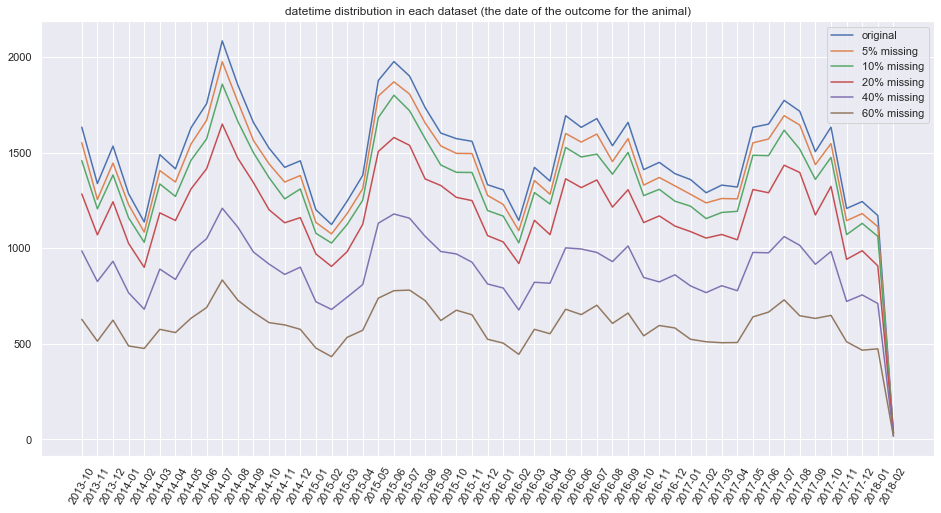

In [15]:
labels = ["original", "5% missing", "10% missing", "20% missing", "40% missing", "60% missing"]

plt.plot(df.groupby("datetime")["datetime"].count())
plt.plot(test_5.groupby("datetime")["datetime"].count())
plt.plot(test_10.groupby("datetime")["datetime"].count())
plt.plot(test_20.groupby("datetime")["datetime"].count())
plt.plot(test_40.groupby("datetime")["datetime"].count())
plt.plot(test_60.groupby("datetime")["datetime"].count())

plt.title("datetime distribution in each dataset (the date of the outcome for the animal)")
plt.legend(labels)
plt.xticks(rotation=60)
plt.plot()

And again the random drop of some values confirms that the distribution stays almost the same, except for some small differences. Of course bigger the % of missing values, the higher the chance that the full dataset would be more different. Now that we checked our datasets, lets try to fill the gaps !

##### <font color=#b59700>dropping the values</font>
Well, we do not need to test this option, as the plots above showed us, how the dataset would look like (they ignore the NaN values). You can ask why not just drop all the missing values if the dataset looks practicaly the same. The reason is, when working with real projects, the missing values wont be missing as equally as here, there may be some specific group who didnt fill the data that would sway the outcome in one way or the other and ignoring that fact might misinterpret the data.

So before you start with working with your dataset, do your homework ! make some statistics, look into the database closer and try to understand it, get it under you skin as deep as you can, so you know exactly how to clean and fill it. If you miss 2% of data from a 10M database, you could mostly drop it without a worry, but when you have only limited amount of data on which you want to learn your model, every single input might hold an invaluable importance. So before you drop something, make sure you thought through all options.

##### <font color=#b59700>filling missing values</font>
Ok, lets start to fill the missing data with basic functions, like:
* fill with average
* fill with value above/under

and lets see if there is some significatn difference

In [16]:
# We know that the most common animal type is dog, but I will demonstrate one handy way to find the most common 

df.groupby("animal_type")["animal_type"].count().idxmax() #idxmax returns the label of max value in series

'Dog'

In [17]:
# create new dataframes
test_5_filled = test_5.copy()
test_20_filled = test_20.copy()
test_60_filled = test_60.copy()

In [18]:
# fill them with specific value
test_5_filled["animal_type"].fillna(value="Dog", inplace=True)
test_20_filled["animal_type"].fillna(value="Dog", inplace=True)
test_60_filled["animal_type"].fillna(value="Dog", inplace=True)

Text(0.5, 1.0, '60% corruption')

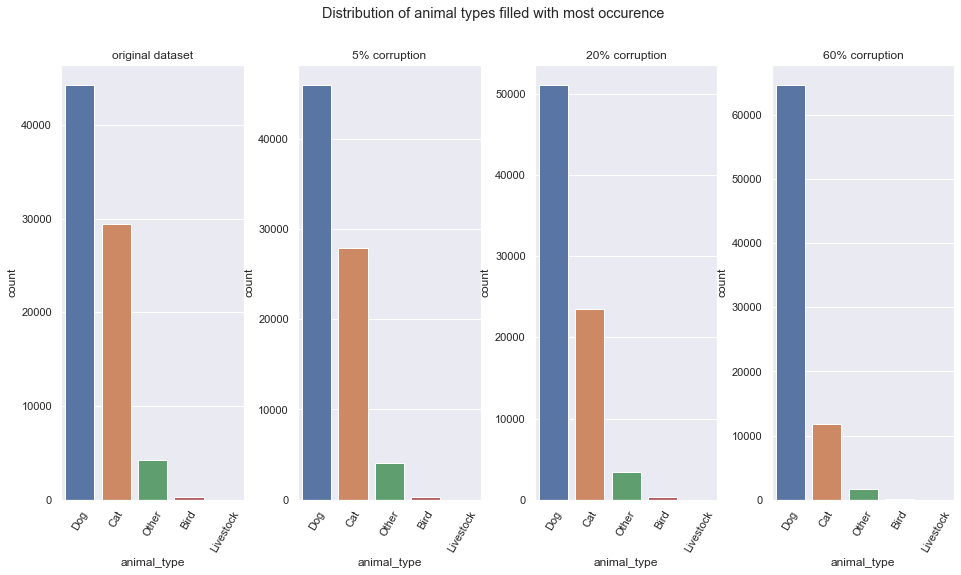

In [19]:
fig, ax = plt.subplots(1,4)
fig.subplots_adjust(wspace=0.3)
fig.suptitle("Distribution of animal types filled with most occurence")

col = "animal_type"
y_axis = "count"

g = sns.barplot(data=sort_by_column(df,col), x=col, y=y_axis, ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=60)
ax[0].set_title("original dataset")

g = sns.barplot(data=sort_by_column(test_5_filled,col), x=col, y=y_axis, ax=ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=60)
ax[1].set_title("5% corruption")

g = sns.barplot(data=sort_by_column(test_20_filled,col), x=col, y=y_axis, ax=ax[2])
g.set_xticklabels(g.get_xticklabels(), rotation=60)
ax[2].set_title("20% corruption")

g = sns.barplot(data=sort_by_column(test_60_filled,col), x=col, y=y_axis, ax=ax[3])
g.set_xticklabels(g.get_xticklabels(), rotation=60)
ax[3].set_title("60% corruption")

No surprise here, more missing values filled with most occurence just deepens the imbalance in the distribution. 

no lets try filling it with the last know data

In [20]:
# reset the filled datasets
test_5_filled = test_5.copy()
test_20_filled = test_20.copy()
test_60_filled = test_60.copy()

# fill them with the last know value
test_5_filled["animal_type"].fillna(method="ffill", inplace=True)
test_20_filled["animal_type"].fillna(method="ffill", inplace=True)
test_60_filled["animal_type"].fillna(method="ffill", inplace=True)

Text(0.5, 1.0, '60% corruption')

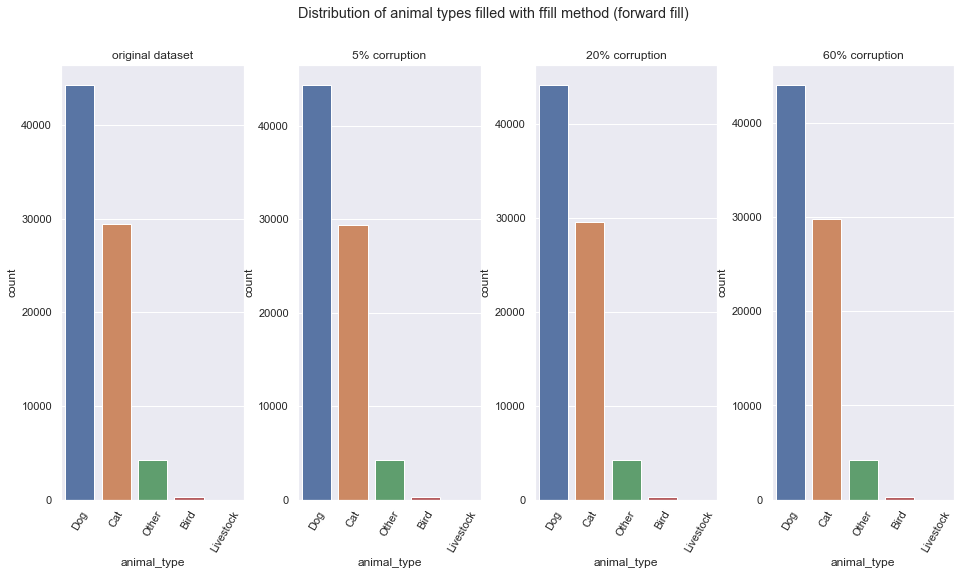

In [21]:
fig, ax = plt.subplots(1,4)
fig.subplots_adjust(wspace=0.3)
fig.suptitle("Distribution of animal types filled with ffill method (forward fill)")

col = "animal_type"
y_axis = "count"

g = sns.barplot(data=sort_by_column(df,col), x=col, y=y_axis, ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=60)
ax[0].set_title("original dataset")

g = sns.barplot(data=sort_by_column(test_5_filled,col), x=col, y=y_axis, ax=ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=60)
ax[1].set_title("5% corruption")

g = sns.barplot(data=sort_by_column(test_20_filled,col), x=col, y=y_axis, ax=ax[2])
g.set_xticklabels(g.get_xticklabels(), rotation=60)
ax[2].set_title("20% corruption")

g = sns.barplot(data=sort_by_column(test_60_filled,col), x=col, y=y_axis, ax=ax[3])
g.set_xticklabels(g.get_xticklabels(), rotation=60)
ax[3].set_title("60% corruption")

We can see that this method made a great job on filling the datasets, but again, this is dataset with only a few classed and evenly distributed missing values. 

Lets try to fill more continuous data, we will fill the datetime of datasets.

In [22]:
test_60_filled["datetime"].fillna(method="ffill", inplace=True)

[]

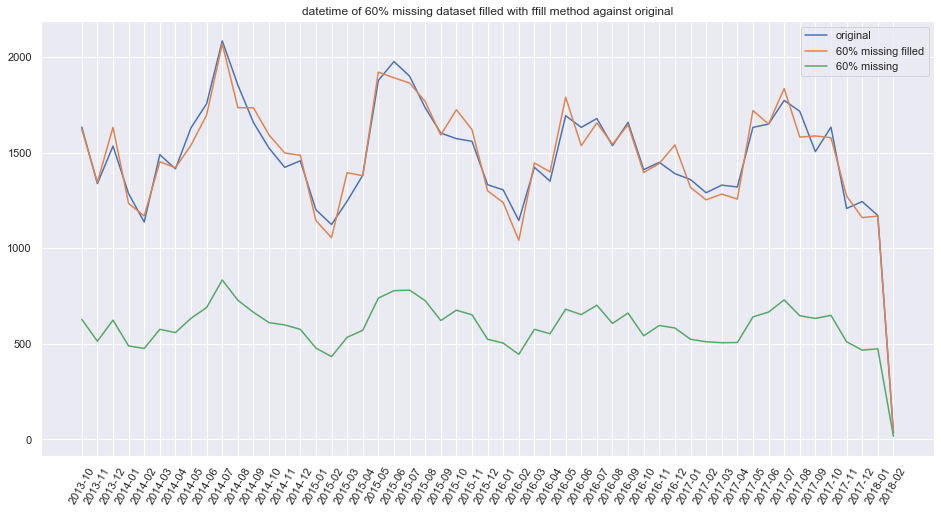

In [23]:
labels = ["original", "60% missing filled", "60% missing"]

plt.plot(df.groupby("datetime")["datetime"].count())
plt.plot(test_60_filled.groupby("datetime")["datetime"].count())
plt.plot(test_60.groupby("datetime")["datetime"].count())
plt.legend(labels)
plt.title("datetime of 60% missing dataset filled with ffill method against original")
plt.xticks(rotation=60)
plt.plot()

And again almost perfect fit. The reason for such a good fit is more or less even distribution of the data. But what if we shuffle the data ? Lets try it

In [24]:
test_60_filled = test_60.copy()
test_60_filled = test_60_filled.sample(frac=1)
test_60_filled["datetime"].fillna(method="ffill", inplace=True)

[]

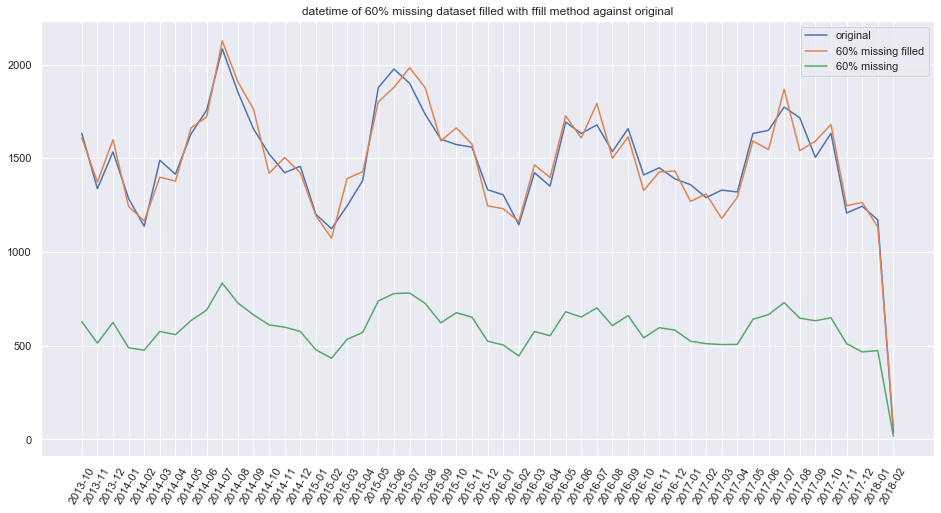

In [25]:
labels = ["original", "60% missing filled", "60% missing"]

plt.plot(df.groupby("datetime")["datetime"].count())
plt.plot(test_60_filled.groupby("datetime")["datetime"].count())
plt.plot(test_60.groupby("datetime")["datetime"].count())
plt.legend(labels)
plt.title("datetime of 60% missing dataset filled with ffill method against original")
plt.xticks(rotation=60)
plt.plot()

And again nice fit. You could run the code above few times, you will always get a little differente outcome, but it will always be close to the original dataset. So even with a lot of data missing, if it is evenly distributed you can pretty much reconstruct it close to its original. Yet, this is really easy dataset for this task and the comparison gives us confidence, but when you will fill some corrupted dataset and have no way to check against reality, thats a whole different story

##### <font color=#b59700>interpolation</font>
interpolation gives you more options on how to fit data. Most of these functions draw from Scipy and are advanced topic. Plus this dataset is not much numericaly oriented, so just to show a few, I will create more dataset where 60% of data is missing and fill it with specific methods, we will use the feature: age upon leaving (this data is more precise up to 1 year, after that it skips by years, so we will plot only 50 weeks)

In [26]:
test_60_interpolate_linear = test_60.copy()
test_60_interpolate_nearest = test_60.copy()
test_60_interpolate_pad = test_60.copy()
test_60_interpolate_linear["out_age_in_weeks"].interpolate(method="linear", inplace=True)
test_60_interpolate_nearest["out_age_in_weeks"].interpolate(method="nearest", inplace=True)
test_60_interpolate_pad["out_age_in_weeks"].interpolate(method="pad", inplace=True)

[]

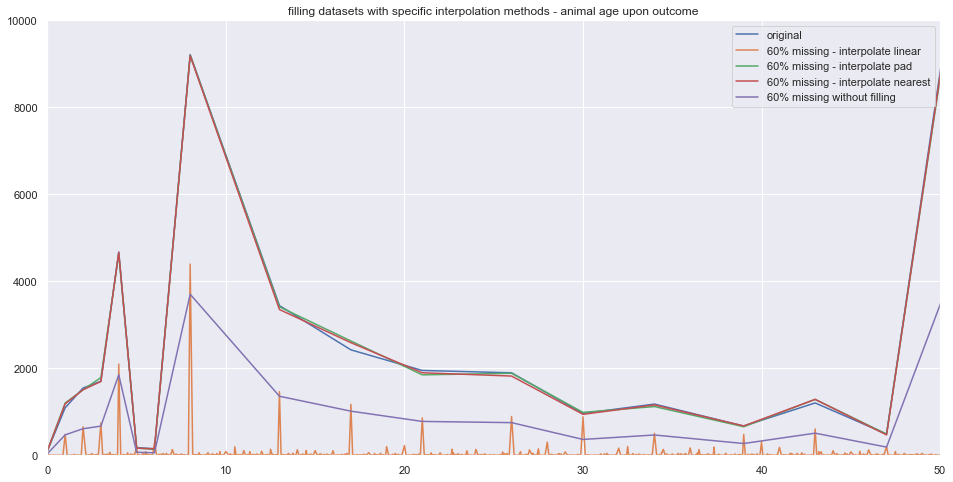

In [27]:
labels = ["original", "60% missing - interpolate linear", "60% missing - interpolate pad", "60% missing - interpolate nearest",  "60% missing without filling"]

plt.plot(df.groupby("out_age_in_weeks")["out_age_in_weeks"].count())
plt.plot(test_60_interpolate_linear.groupby("out_age_in_weeks")["out_age_in_weeks"].count())
plt.plot(test_60_interpolate_pad.groupby("out_age_in_weeks")["out_age_in_weeks"].count())
plt.plot(test_60_interpolate_nearest.groupby("out_age_in_weeks")["out_age_in_weeks"].count())
plt.plot(test_60.groupby("out_age_in_weeks")["out_age_in_weeks"].count())
plt.legend(labels)
plt.title("filling datasets with specific interpolation methods - animal age upon outcome")
plt.xlim(0,50)
plt.ylim(0,10000)
plt.plot()

## <font color=#b59700><center>Final words</center></font>
As you can see, I covered really only the basics of the filling methods. you can create many custom methods to fill the data if you need it specific, or you can use many tested methods from the libraries, especially those from Scipy if you know the math behind it. As I have other notebooks to work on, I leave this one in an -for me- unfinished state and will come back and cover more advanced topics later. Thank you for your time you spend going through this notebook "